# The right price

The aim of this notebook is to use a Multilayer Percerptron (MLP) architecture to predict the price of football players based on some data available about them. The right price (the labeled data for training) comes from transfermrkt.com from 2017. For more details about the dataset, check [here](https://github.com/Lakshaypahuja21/FOOTBALL-ENGLISH_PREMIER_LEAGUE)

# Exploratory Data Analysis (EDA)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import piplite
await piplite.install('seaborn')
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold

First things first! Let's load the data into memory using Pandas:

In [48]:
data_raw = pd.read_csv("price.csv")
data_raw.head(5)

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2,France,0,4,1,1,0


Now we will do some analysis. Which is the highest market value? Which players are worth this amount?

In [49]:
highest_market_value = data_raw.market_value.max()
print(highest_market_value, data_raw[data_raw.market_value == highest_market_value].name.values)

75.0 ['Eden Hazard' 'Paul Pogba']


Do the same for the least valuable players:

In [50]:
lowest_market_value = data_raw.market_value.min()
print(lowest_market_value, data_raw[data_raw.market_value == lowest_market_value].name.values)

0.05 ['Eduardo Carvalho']


Now, lets select some variables. Create a dataframe containing only the variables **name, age, position, market_value, page_views, fpl_value, fpl_sel, region, big_club, new_signing**.

In [51]:
data = data_raw[['name', 'age', 'position', 'market_value', 'page_views',
              'fpl_value', 'fpl_sel', 'region', 'big_club', 'new_signing']].copy()

Now, some names are too long. Rename: position for pos, market_value for value, page_views for views and new signing for signing.

In [52]:
data.rename(columns = {'position': 'pos', 'market_value':'value', 'page_views':'views',
            'new_signing':'signing'}, inplace = True)

data.head(5)

,name,age,pos,value,views,fpl_value,fpl_sel,region,big_club,signing
0,Alexis Sanchez,28,LW,65.0,4329,12.0,17.10%,3,1,0
1,Mesut Ozil,28,AM,50.0,4395,9.5,5.60%,2,1,0
2,Petr Cech,35,GK,7.0,1529,5.5,5.90%,2,1,0
3,Theo Walcott,28,RW,20.0,2393,7.5,1.50%,1,1,0
4,Laurent Koscielny,31,CB,22.0,912,6.0,0.70%,2,1,0


The fpl_sel variable has the "%" sign on it and won't be interpreted by the algorithm. The following line handles with this:


In [53]:
data['fpl_sel'] = data['fpl_sel'].replace('%','',regex=True).astype('float')

Now, for each position let's print the average value (fpl_value) of the players. Which positions are the most, and least valued?

In [54]:
positions = data['pos'].unique()

for pos in positions:
    mean = data.loc[data['pos']==pos]['fpl_value'].mean()
    print("Average fpl_value for %s is : %.2f" % (pos, mean))


Average fpl_value for LW is : 6.07
Average fpl_value for AM is : 7.44
Average fpl_value for GK is : 4.65
Average fpl_value for RW is : 6.00
Average fpl_value for CB is : 4.85
Average fpl_value for RB is : 4.94
Average fpl_value for CF is : 6.69
Average fpl_value for LB is : 5.00
Average fpl_value for DM is : 4.78
Average fpl_value for RM is : 5.60
Average fpl_value for CM is : 5.24
Average fpl_value for SS is : 6.43
Average fpl_value for LM is : 5.06


Let's now generate a new column fpl_value_dist with the difference between the fpl_value of a player and the mean of the players in the same position

In [55]:
mean_values = data.groupby('pos')['fpl_value'].transform('mean')
data['fpl_value_dist'] = data['fpl_value'] - mean_values
data.head()

,name,age,pos,value,views,fpl_value,fpl_sel,region,big_club,signing,fpl_value_dist
0,Alexis Sanchez,28,LW,65.0,4329,12.0,17.1,3,1,0,5.930556
1,Mesut Ozil,28,AM,50.0,4395,9.5,5.6,2,1,0,2.058824
2,Petr Cech,35,GK,7.0,1529,5.5,5.9,2,1,0,0.845238
3,Theo Walcott,28,RW,20.0,2393,7.5,1.5,1,1,0,1.500000
4,Laurent Koscielny,31,CB,22.0,912,6.0,0.7,2,1,0,1.147059


The new fpl_value_dist variable allows us to compare the fpl_value between different players in different positions in a "fair" way. Let's retrieve the top and least "valuable" players. To do so, sort the dataframe based on the value of fpl_value_dist and display the 5 upper rows and the 5 lower rows of the ordered dataset

In [56]:
data = data.sort_values('fpl_value_dist')
data.head(5)

,name,age,pos,value,views,fpl_value,fpl_sel,region,big_club,signing,fpl_value_dist
118,Jason Puncheon,31,AM,5.50,427,5.0,1.2,1,0,0,-2.441176
300,Siem de Jong,28,AM,5.50,341,5.0,0.1,2,0,0,-2.441176
372,Oliver McBurnie,21,CF,0.25,149,4.5,0.7,2,0,0,-2.188525
186,Collin Quaner,26,CF,1.00,126,4.5,1.6,2,0,0,-2.188525
305,Daryl Murphy,34,CF,1.50,541,4.5,2.8,2,0,0,-2.188525


In [57]:
data.tail(5)

,name,age,pos,value,views,fpl_value,fpl_sel,region,big_club,signing,fpl_value_dist
92,Eden Hazard,26,LW,75.0,4220,10.5,2.3,2,1,0,4.430556
241,Sergio Aguero,29,CF,65.0,4046,11.5,9.7,3,1,0,4.811475
260,Romelu Lukaku,24,CF,50.0,3727,11.5,45.0,2,1,0,4.811475
377,Harry Kane,23,CF,60.0,4161,12.5,35.1,1,1,0,5.811475
0,Alexis Sanchez,28,LW,65.0,4329,12.0,17.1,3,1,0,5.930556


Let's do some statistical analysis: Print the pearson correlation matrix between all the numeric variables. 

In [58]:
# data_numeric will contain the numeric variables:
data_numeric = data.select_dtypes(include = np.number)
corr = data_numeric.corr()
print(corr)

                     age     value     views  fpl_value   fpl_sel    region  \
age             1.000000 -0.132396 -0.048682  -0.097659 -0.003018  0.091356   
value          -0.132396  1.000000  0.739657   0.788653  0.548703  0.103188   
views          -0.048682  0.739657  1.000000   0.730640  0.524926  0.034315   
fpl_value      -0.097659  0.788653  0.730640   1.000000  0.504888  0.080180   
fpl_sel        -0.003018  0.548703  0.524926   0.504888  1.000000 -0.050881   
region          0.091356  0.103188  0.034315   0.080180 -0.050881  1.000000   
big_club       -0.123566  0.593483  0.502982   0.423556  0.269498  0.041853   
signing        -0.079190  0.131321  0.127249   0.098314 -0.026993  0.177744   
fpl_value_dist  0.007184  0.790009  0.673875   0.811899  0.563669  0.065483   

                big_club   signing  fpl_value_dist  
age            -0.123566 -0.079190        0.007184  
value           0.593483  0.131321        0.790009  
views           0.502982  0.127249        0.673875

Now we can visualize the correlation matrix using the [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function from seaborn.

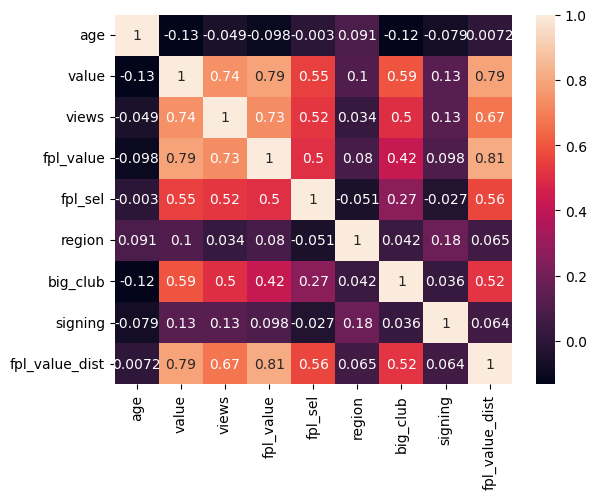

In [59]:
sns.heatmap(corr, annot=True)
plt.show()

Now we will do a [boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html) to see how the outcome variable (price) is distributed between postions.

Positions naming:

1. AM: attacking midfielder
2. CF: center forward
3. LW: left wing
4. RW: right wing
5. SS: second stricker 
6. RM: right midfielder
7. LB: left back defender
8. RB: right back defender
9. CB: center back defender
10. CM: center midfielder
11. GK: goal keeper
12. LM: left midfielder
13. DM: defensive midfielder


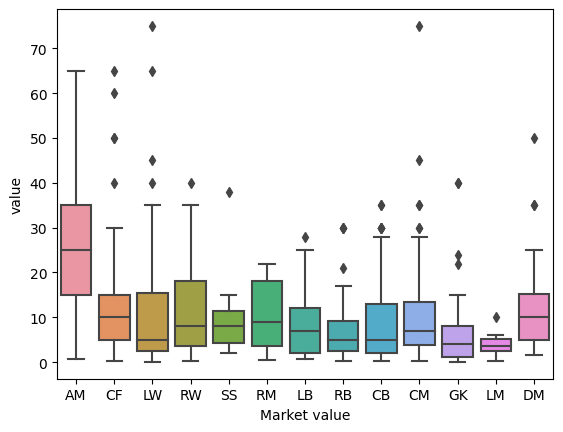

In [60]:
sns.boxplot(y='value', x='pos',data=data)
plt.xlabel('Market value')
plt.show()

Let's do the same visualization to compare players who are signing a new contract and those that are not.

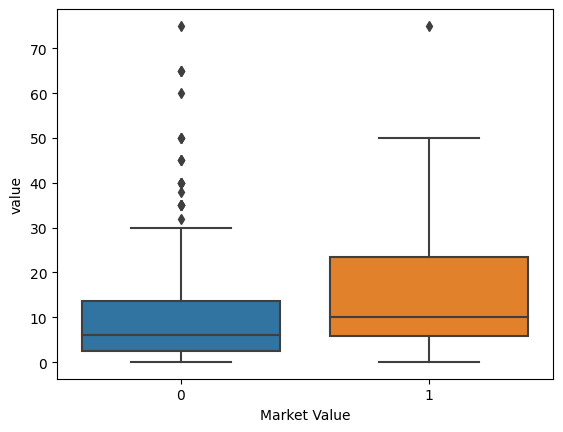

In [61]:
sns.boxplot(y='value', x='signing',data=data)
plt.xlabel("Market Value")
plt.show()

We can also try to find relations between the price and the views or the price and the % of fpl selection. Create a [scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) plot between this variables.

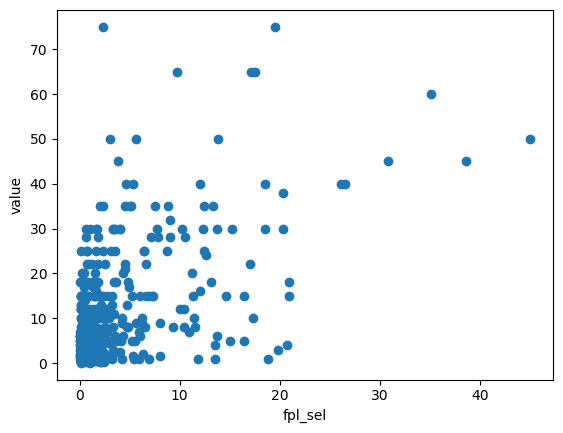

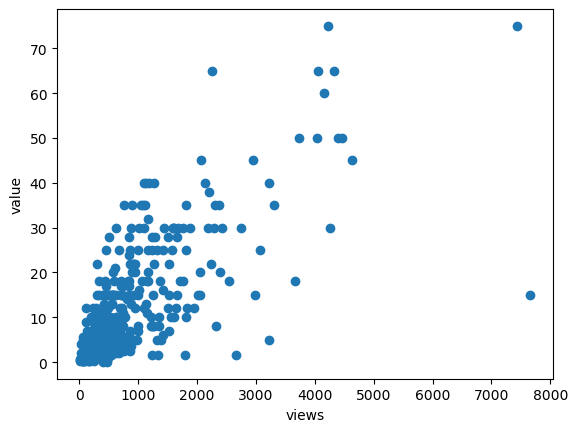

In [62]:
plt.scatter(data['fpl_sel'], data['value'])
plt.xlabel('fpl_sel')
plt.ylabel('value')
plt.show()

plt.scatter(data['views'], data['value'])
plt.xlabel('views')
plt.ylabel('value')
plt.show()

Notice the most viewed player is very cheap. Who is him? Print his name!

In [63]:
print(data[data['views']==data.views.max()].name.values)

['Wayne Rooney']


Lastly to use a ML model with theis dataset we have to format the categorical variables and convert them into dummies. 

In [64]:
data = pd.get_dummies(data, columns = ['pos', 'big_club', 'region', 'signing'])

# Generate train - test split

In [65]:
y = data['value']
X = data.drop('value', axis = 1)

We have to scale the data between 0 and 1. Do it without using any function from sklearn by applying the formula: 

$$ scaled variable = \frac{variable-minimum}{maximum-minimum}$$

In [66]:
# predictors are all variables except the name of the player
predictors = X.columns
predictors = predictors.drop('name')

#store the values for later use:
minimum = X[predictors].min()
maximum = X[predictors].max()

#scale
X[predictors] = (X[predictors]-minimum)/(maximum-minimum)

Now let's make the train/test split by keeping 70% of the data as training data

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

In [68]:
names_train = X_train['name']
names_test = X_test['name']
X_train = X_train.drop('name', axis = 1)
X_test = X_test.drop('name', axis = 1)

# Model selection

Create two different models and try k-fold (with k = 5) cross validation to choose the best one. The first model should have only one hidden layer with 20 neurons and the second one 2 hidden layers with 10 neurons each. Both models should have max_iter=8000. 

Create the first model

In [69]:
mlp1 = MLPRegressor(hidden_layer_sizes=(20), max_iter=5000)

Create the second one

In [70]:
mlp2 = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=8000)

Now we will use k-fold crossvalidation to select the best model. Before that, we need to transform the dataframes into numpy arrays

In [71]:
X_train_arr = np.array(X_train)
X_test_arr = np.array(X_test)
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)


Complete the code below to perform [k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) crossvalidation. We want to store the MSE in each iteration in the corresponding error list:

In [72]:
kf = KFold(n_splits=5, shuffle = True, random_state = 33)

kf_error1 = []
kf_error2 = []

for train_index, test_index in kf.split(X_train_arr):

    X_train_kf, X_test_kf = X_train_arr[train_index], X_train_arr[test_index]
    y_train_kf, y_test_kf = y_train_arr[train_index], y_train_arr[test_index]
    
    mlp1.fit(X_train_kf, y_train_kf)
    mlp2.fit(X_train_kf, y_train_kf)
    
    predictions1 = mlp1.predict(X_test_kf)
    predictions2 = mlp2.predict(X_test_kf)
    
    mse1 = np.mean((predictions1 - y_test_kf)**2)
    mse2 = np.mean((predictions2 - y_test_kf)**2)

    kf_error1.append(mse1)
    kf_error2.append(mse2)
    

In [73]:
next(kf.split(X_train))

(array([  0,   2,   3,   5,   6,   7,   8,   9,  10,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         30,  31,  32,  33,  34,  36,  37,  38,  39,  40,  41,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  53,  54,  55,  57,  59,  60,
         61,  63,  64,  65,  66,  67,  68,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  82,  83,  84,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  96,  97,  98,  99, 100, 102, 103, 104, 105,
        106, 107, 108, 109, 111, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 123, 124, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150,
        151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 167,
        168, 169, 170, 171, 172, 173, 175, 176, 177, 179, 180, 183, 184,
        185, 186, 188, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200,
        201, 202, 203, 205, 206, 207, 208, 209, 210

Print the average cross-validation errors for the two models, which model had the best overall performance?

In [29]:
print(sum(kf_error1)/5, sum(kf_error2)/5)

44.69176917850681 51.35791360306346


# Model evaluation

Now, let's retrain the best model configuration it using the full training data available

In [30]:
mlp_best = MLPRegressor(hidden_layer_sizes=(20), max_iter=8000)

In [32]:
# fit the model with the whole training data
mlp_best.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=20, max_iter=8000)

Predict the values for the testing dataset. Compute the Mean Squared Error and the Mean Absolute Error.

In [33]:
predictions = mlp_best.predict(X_test)

MSE = np.mean((predictions-y_test)**2)
MAE = np.mean(np.abs(predictions-y_test))

print(MSE)
print(MAE)

27.62357113184716
3.8275930647519285


Now we can create an imaginary player by deciding arbitrary values for the variables. Check how the predicted price changed as you modify the different variables!

In [ ]:
data.loc[100]

In [35]:
# Generate the variables for the player
new_player = [30,2378, 7, 7.5, 1.7619,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0]

# Standardize the variables
new_player = (new_player-minimum)/(maximum-minimum)

# Predict the price
price = mlp_best.predict([new_player])

/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


In [36]:
price

array([34.80812814])